# Smoothing with Wave Transform Preprocessing

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from crypr.data import get_data
from crypr.util import common

from crypr.features.build_features import make_single_feature, series_to_predict_matrix, make_features, data_to_supervised
from crypr.features.wavelets import *

from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
import pywt

import pickle
import gc
p=print

In [3]:
SYM='BTC'
LAST_N_HOURS=16000
TARGET='close'
Tx = 72
Ty = 1
TEST_SIZE=0.05

In [4]:
data = pd.read_csv('../data/raw/{}.csv'.format(SYM), index_col=0)

In [5]:
"""
Get percent change feature and target data.
"""
df=make_single_feature(input_df=data, target_col='close', train_on_x_last_hours=LAST_N_HOURS)
X, y = data_to_supervised(input_df=pd.DataFrame(df['target']), Tx=Tx, Ty=Ty)
p(X.shape, y.shape)
X.head()

(15927, 72) (15927, 1)


,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
28075,-0.973867,0.040380,-0.151038,0.131706,0.117207,-0.180808,-0.169408,-0.035244,-0.086183,0.388159,...,-0.156730,0.229030,0.290127,-0.273927,-0.001284,-0.205370,0.227659,0.030799,-0.118026,0.050092
28076,0.040380,-0.151038,0.131706,0.117207,-0.180808,-0.169408,-0.035244,-0.086183,0.388159,0.143207,...,0.229030,0.290127,-0.273927,-0.001284,-0.205370,0.227659,0.030799,-0.118026,0.050092,-0.631611
28077,-0.151038,0.131706,0.117207,-0.180808,-0.169408,-0.035244,-0.086183,0.388159,0.143207,-0.130002,...,0.290127,-0.273927,-0.001284,-0.205370,0.227659,0.030799,-0.118026,0.050092,-0.631611,0.245465
28078,0.131706,0.117207,-0.180808,-0.169408,-0.035244,-0.086183,0.388159,0.143207,-0.130002,-0.117154,...,-0.273927,-0.001284,-0.205370,0.227659,0.030799,-0.118026,0.050092,-0.631611,0.245465,0.021909
28079,0.117207,-0.180808,-0.169408,-0.035244,-0.086183,0.388159,0.143207,-0.130002,-0.117154,0.303654,...,-0.001284,-0.205370,0.227659,0.030799,-0.118026,0.050092,-0.631611,0.245465,0.021909,0.462563


In [6]:
"""
Confirm data reshape and target/feature creation was done correctly.
"""
y_values_except_last = np.squeeze(y.iloc[:-1].values)
t_minus_1_x_values_except_first = X.iloc[1:,-1].values

y_values_except_last.all() == t_minus_1_x_values_except_first.all()

True

In [7]:
"""
For comparing different transformations
"""
sample_ix = 1000
sample=X.iloc[sample_ix].values

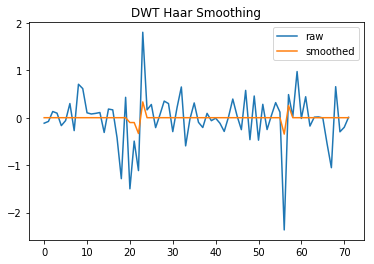

In [9]:
"""
DWT Haar Transform
"""
def dwt_smooth(x, wavelet):
    cA, cD = pywt.dwt(x, wavelet)
    
    def make_threshold(x):
        return np.std(x)*np.sqrt(2*np.log(x.size))
    
    cAt = pywt.threshold(cA, make_threshold(cA), mode="soft")                
    cDt = pywt.threshold(cD, make_threshold(cD), mode="soft")                
    tx = pywt.idwt(cAt, cDt, wavelet)
    return tx

plt.plot(sample, label='raw')
plt.plot(dwt_smooth(sample, 'haar'), label='smoothed')
plt.title('DWT Haar Smoothing')
plt.legend()
plt.show()

In [10]:
X.shape

(15927, 72)

In [11]:
"""
Apply the wavelet transformation smoothing to the feature data.
"""
wt_type='haar'
smooth_fun = lambda x: dwt_smooth(x, wt_type)
X_sm = np.apply_along_axis(func1d=smooth_fun, axis=-1, arr=X)

assert X_sm.shape == X.shape

In [12]:
"""
Train Test Split.
"""
X_train, X_test, y_train, y_test = train_test_split(X_sm, y, test_size=TEST_SIZE, shuffle=False)

In [14]:
"""
Save data.
"""
np.save(arr=X_train, file='../data/processed/X_train_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
np.save(arr=X_test,  file='../data/processed/X_test_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
np.save(arr=y_train, file='../data/processed/y_train_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
np.save(arr=y_test,  file='../data/processed/y_test_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))